In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
df_10_20 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-20.csv").dropna()
df_10_27 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-27.csv").dropna()
df_11_03 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-03.csv").dropna()
df_11_10 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-10.csv").dropna()
df_11_17 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-17.csv").dropna()
df_11_22 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-22.csv").dropna()

In [3]:
def preprocess_spectra(df):
    return average_dataframe(df, 15).drop("Wavelengths", 1).as_matrix().transpose()

def average_dataframe(df, n):
    # Separate label column from data
    label = df.iloc[:,0]
    df = df.iloc[:,1:]

    if (df.shape[1]) % n != 0:
        raise Exception("Number of columns: {}. Not divisible by {}.".format(df.shape[1], n))

    # Average every N columns
    average_df = pd.DataFrame()
    average_df["Wavelengths"] = label
    for i in range((df.shape[1]) // n):
        average_df[i] = df.iloc[:,i*n:(i+1)*n].mean(axis=1)

    return average_df

In [4]:
spectra_10_20 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-20.csv")), list(range(1, 96, 2)), axis=0)
spectra_10_27 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-27.csv")), list(range(1, 96, 2)), axis=0)
spectra_11_03 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-03.csv")), list(range(1, 96, 2)), axis=0)
spectra_11_10 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-10.csv")), list(range(1, 96, 2)), axis=0)
spectra_11_17 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-17.csv")), list(range(1, 96, 2)), axis=0)
spectra_11_22 = np.delete(preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-22.csv")), list(range(1, 96, 2)), axis=0)

In [5]:
print(spectra_10_20.shape)
print(spectra_10_27.shape)
print(spectra_11_03.shape)
print(spectra_11_10.shape)
print(spectra_11_17.shape)
print(spectra_11_22.shape)

(48, 751)
(48, 751)
(48, 751)
(48, 751)
(48, 751)
(48, 751)


In [18]:
spectra = np.concatenate([spectra_10_20, spectra_10_27, spectra_11_03, spectra_11_10, spectra_11_17, spectra_11_22], axis=0)
df = pd.concat([df_10_20, df_10_27, df_11_03, df_11_10, df_11_17, df_11_22])

In [20]:
spectra.shape, df["WP"].shape

((288, 751), (288,))

# Train Predictor

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(spectra, df["WP"], test_size=0.15)

In [32]:
from sklearn.linear_model import LinearRegression, Lasso
reg = LinearRegression()
reg.fit(X_train, y_train)
print(mean_absolute_error(reg.predict(X_train), y_train))
print(mean_absolute_error(reg.predict(X_valid), y_valid))

3.83973818133e-13
2.62215458443


In [33]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=500)
mlp.fit(X_train, y_train)
print(mean_absolute_error(mlp.predict(X_train), y_train))
print(mean_absolute_error(mlp.predict(X_valid), y_valid))

1.21172649135
1.28754061081


1.4696715784865375

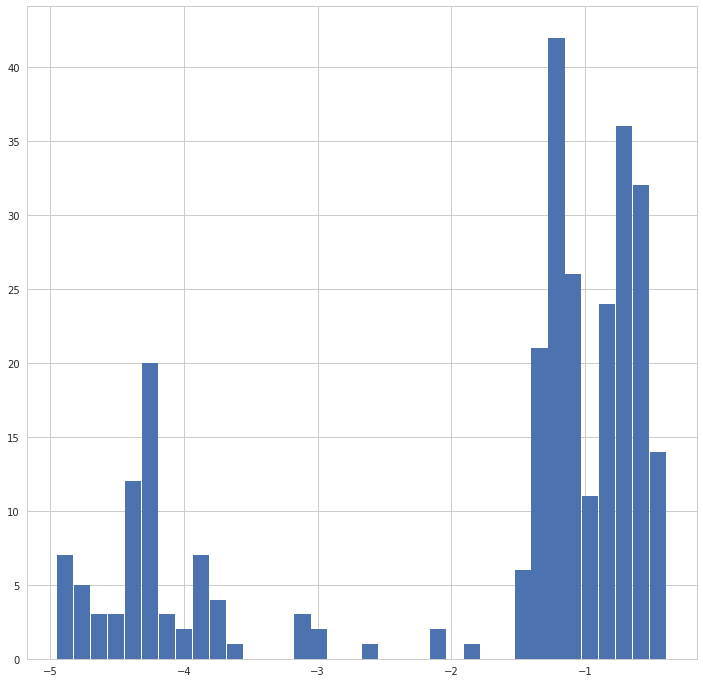

In [34]:
plt.hist(df["WP"], 36, rwidth=0.95)
np.std(wp)

# Testing Various Indices

In [63]:
# We subtract 325 because the 0 index is 325nm
df["YELLOW1"] = spectra[:, 550-325]
df["RED1"] = spectra[:, 680-325]
df["RED3"] = spectra[:, 670-325]
df["NIR1"] = spectra[:, 800-325]
df["NIR3"] = spectra[:, 900-325]
df["NIR4"] = spectra[:, 970-325]
df["NIR5"] = spectra[:, 700-325]

In [56]:
df["WBI"] = df["NIR3"] / df["NIR4"]
stats.pearsonr(df["WBI"], df["WP"])

(-0.0064921844824051399, 0.912648864667437)

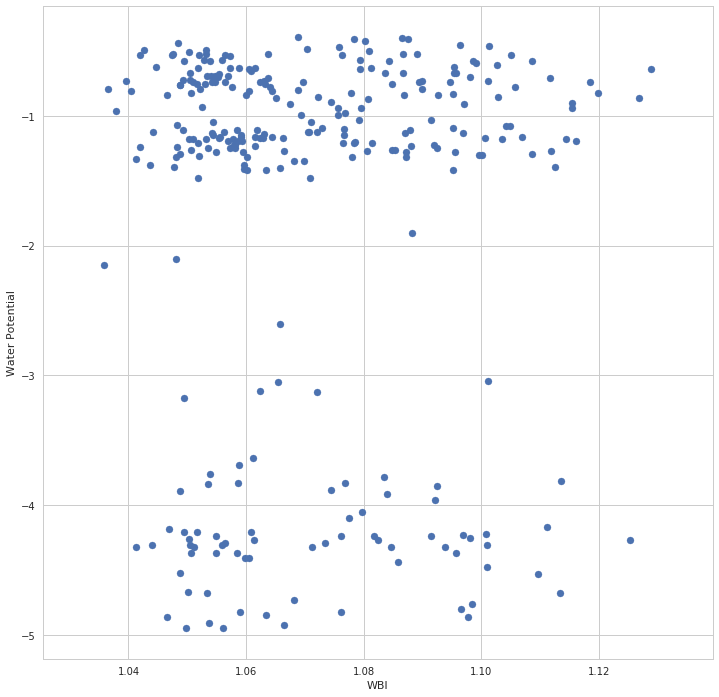

In [50]:
fig = plt.figure
plt.scatter(df["WBI"], df["WP"])
plt.xlabel("WBI")
plt.ylabel("Water Potential")

In [40]:
print(df[df["Irrigation"] == 100]["WBI"].mean())
print(df[df["Irrigation"] == 50]["WBI"].mean())
print(df[df["Irrigation"] == 25]["WBI"].mean())
print(df[df["Irrigation"] == 0]["WBI"].mean())

1.07333149335
1.06924714397
1.07115446622
1.07217638491


In [57]:
print(df[df["Irrigation"] == 100]["NIR4"].mean())
print(df[df["Irrigation"] == 50]["NIR4"].mean())
print(df[df["Irrigation"] == 25]["NIR4"].mean())
print(df[df["Irrigation"] == 0]["NIR4"].mean())

0.77586566654
0.778704312013
0.767236461182
0.76278214852


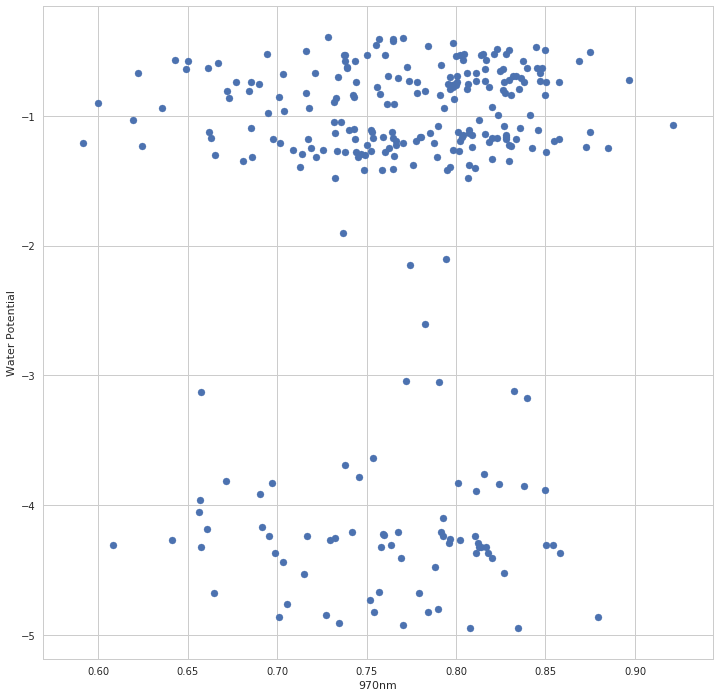

In [52]:
fig = plt.figure
plt.scatter(df["NIR4"].values, wp)
plt.xlabel("970nm")
plt.ylabel("Water Potential")

In [71]:
ndvi = (df["NIR1"] - df["RED1"]) / (df["NIR1"] + df["RED1"])
stats.pearsonr(ndvi, df["Chlorophyll"]), stats.pearsonr(ndvi, df["WP"])

((-0.20340449643024447, 0.00051418527971254697),
 (-0.0018763907858658725, 0.97470734788510638))

In [72]:
df["rededge"] = df["NIR5"] / df["RED3"]
stats.pearsonr(df["rededge"], df["Chlorophyll"]), stats.pearsonr(df["rededge"], df["WP"])

((-0.2140476416181204, 0.00025299312811613263),
 (0.10939269252988669, 0.063746395869270431))

In [73]:
df["MCARI"] = (df["NIR5"] / df["RED3"]) - 0.23 * (df["NIR5"] - df["YELLOW1"]) * df["NIR5"] / df["RED3"]
stats.pearsonr(df["MCARI"], df["Chlorophyll"]), stats.pearsonr(df["MCARI"], df["WP"])

((-0.21279612989616409, 0.00027549954202349744),
 (0.10940148338699514, 0.063724953366578976))

In [74]:
NIR = spectra[:, 800-325]
GREEN = spectra[:, 550]
df["GNDVI"] = (NIR - GREEN) / (NIR + GREEN)
stats.pearsonr(df["GNDVI"], df["Chlorophyll"]), stats.pearsonr(df["GNDVI"], df["WP"])

((-0.11489407069181269, 0.051439836162453068),
 (0.053049628023306927, 0.36971969707746632))